## Task 1: Activation Functions and FF pre-trained Neural Network <br/> CC6204 Deep Learning, Universidad de Chile.
#### Name: Humberto Rodrigues

In [1]:
import torch
import torch.nn as nn

# Autocorrect utility
!pip install "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"

In [2]:
# Importing Autocorrect
from cc6204 import AutoCorrect
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl",port="443")
token = "]ye/Ox;nsz"

Connection stablished


## Part 1: Non-Linear Activation and output Functions

* ### Non-Linear Activation Functions:

In [3]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T):
  return torch.max(T,torch.zeros(T.size(),device=T.device))

def swish(T, beta=1.0):
  return T * sig(beta * T)

def celu(T, alpha=1.0):
  zero_T = torch.zeros(T.size(),device=T.device)
  return torch.max(T,zero_T) + torch.min(alpha * (torch.exp(T/alpha) - 1),zero_T)

In [4]:
# Downloading external test data for each activation function
test_relu = corrector.get_test_data(homework=1, question="1a", test=1, token=token)
test_swish, swish_par = corrector.get_test_data(homework=1, question="1a", test=2, token=token)
test_celu, celu_par = corrector.get_test_data(homework=1, question="1a", test=3, token=token)

corrector.sumbit(homework=1, question="1a", test=1, token=token, answer=relu(torch.tensor(test_relu)))
corrector.sumbit(homework=1, question="1a", test=2, token=token, answer=swish(torch.tensor(test_swish), swish_par))
corrector.sumbit(homework=1, question="1a", test=3, token=token, answer=celu(torch.tensor(test_celu), celu_par))

Correct Test!
Correct Test!
Correct Test!


* ### Output Function, Softmax:

The first thing is that We need to define a computational stable variation of the `softmax` but avoiding changes in the
result. A pretty common solution for this problem is to find the `max` value inside the tensor and subtracts it to each
element of the collection. Applying this method changes the definition of the `softmax` to this:

$\text{softmax}(x_1,\ldots,x_n)$ is another collection $(s_1,\ldots,s_n)$ where
\begin{equation}
s_i = \frac{e^{x_i - M}}{\sum_{j=1}^{n}e^{x_j-M}}
\end{equation} being `M` the max value previously mentioned.

The next step is to demonstrate that the addition of `M`  won't affect the results:

Steps:
* Applying exponent rules ($e^{a-b} =  \frac{e^{a}}{e^{b}}$):
\begin{equation}
s_i = \frac{\frac{e^{x_i}}{e^{M}}}{\sum_{j=1}^{n}\frac{e^{x_j}}{e^{M}}}
\end{equation}
* We can extract the constant $\frac{1}{e^{M}}$ from the summatory because there is no dependency with `j`:
\begin{equation}
s_i = \frac{\frac{e^{x_i}}{e^{M}}}{\frac{\sum_{j=1}^{n}e^{x_j}}{e^{M}}}
\end{equation}

* The next step is to apply the double `C` Rule for fractions:
\begin{equation}
s_i = \frac{e^{x_i}\cdot e^{M}}{e^{M} \cdot {\sum_{j=1}^{n}e^{x_j}}}
\end{equation}

* Finally the $e^{M}$ constants cancel each other and we obtain the original definition of the `softmax`:
\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}

In [5]:
def softmax(T, dim=1, stable=True):
  maxes = torch.max(T, dim, keepdim=True)[0] if stable else 0
  x_exp = torch.exp(T-maxes)
  x_exp_sum = torch.sum(x_exp, dim, keepdim=True)
  return x_exp/x_exp_sum

In [6]:
# Downloading external test data for output function
test_softmax, _dim = corrector.get_test_data(homework=1, question="1b", test=1, token=token)
corrector.sumbit(homework=1, question="1b", test=1, token=token, answer=softmax(torch.tensor(test_softmax), dim=_dim))

Correct Test!


## Part 2: Building a Feed Forward Neural Network

In [8]:
class FFNN(torch.nn.Module):
  def create_parameters(self, h_l, l_a, C, extra=None,initial_weights=None):
    internal_layers = []
    internal_biases = []
    for i in range(0, len(h_l)-1):
      if initial_weights:
        # The structure with initial weights for the `lth` layer will be (W,b)
        # We need to ensure that the dimensions of the data MATCH with the model
        current_weights = initial_weights[i][0]
        current_bias = initial_weights[i][1]
        if len(current_weights) != h_l[i] or len(current_weights[0]) != h_l[i+1] or len(current_bias) != h_l[i+1]:
          raise Exception("Dimension mismatch")
        else:
          internal_layers.append(nn.Parameter(current_weights))
          internal_biases.append(nn.Parameter(current_bias))
      else:
        internal_layers.append(nn.Parameter(torch.randn(h_l[i],h_l[i+1])))
        internal_biases.append(nn.Parameter(torch.zeros(h_l[i+1])))

    self.h_weights = nn.ParameterList(internal_layers)
    self.biases = nn.ParameterList(internal_biases)
    self.activation_functions = l_a[:-1]
    self.extra_params = extra

    # Output Layer, bias (c), and softmax 
    # It is important to notice the use of ParameterList also for this layer
    # This is because the nn.Parameter directly is not being reflected in the 
    # print(model) method and that is the one being used for the summary 

    if initial_weights:
      # Is expected that the last position of `initial_weights` is (U,c)
      output_weights = initial_weights[-1][0]
      output_bias = initial_weights[-1][1]

      if len(output_weights) != h_l[-1] or len(output_weights[0]) != C or len(output_bias) != C:
          raise Exception("Dimension mismatch")
      else:
        self.output_weights = nn.ParameterList([nn.Parameter(output_weights)])
        self.output_bias = nn.ParameterList([nn.Parameter(output_bias)])
    else:
      self.output_weights = nn.ParameterList([nn.Parameter(torch.randn(h_l[-1],C))])
      self.output_bias = nn.ParameterList([nn.Parameter(torch.zeros(C))])
    self.output_function = l_a[-1]

  def __init__(self, F, l_h, l_a, C, extra=None, initial_weights=None):
    super(FFNN, self).__init__()

    if len(l_h)+1 != len(l_a):
      raise Exception("Dimension mismatch")
    if extra and len(extra) != len(l_a):
      raise Exception("Dimension mismatch")
    if initial_weights and len(initial_weights) != (len(l_h) + 1):
      raise Exception("Dimension mismatch")

    self.create_parameters([F]+l_h,l_a,C,extra,initial_weights)
  
  def summary(self):
    
    # In this case the summary is being show using the string method defined in the class
    # because is easy to see the details of all the internal parameters
    # also the use of this string method is the reason of addding output weights
    # as a paremetertList to be able to see it Listed here. 

    print(f"#######MODEL SUMMARY#######\n")
    print(f"Input Layer size: {self.h_weights[0].size()[0]}\n")
    print("Internal params detail:")
    print(f"{self}")
    print(f"Activation Functions{[f.__name__ for f in self.activation_functions+[self.output_function]]}\n")
    print(f"Extra Params{self.extra_params}\n")
    print(f"Output Layer size: {self.output_weights[0].size()[1]}\n")
    print(f"Total trainable Parameters: { sum(p.numel() for p in self.parameters() if p.requires_grad)}")
    print(f"Total Parameters: { sum(p.numel() for p in self.parameters())}\n")
    print(f"########SUMMARY END########\n\n")
  
  def forward(self, x):
    for i in range(0, len(self.h_weights)):
      # Validation to retrieve the possible extra params for the i_th activation function
      current_extras = self.extra_params[i] if self.extra_params and self.extra_params[i] else {}

      # H = x * W + b
      x =  self.activation_functions[i](torch.matmul(x,self.h_weights[i]) + self.biases[i],**current_extras)

    # Validation to retrieve the possible extra params for the output activation function
    output_extras = self.extra_params[-1] if self.extra_params and self.extra_params[i] else {}

    # y' = x * U + c
    x = self.output_function(torch.matmul(x,self.output_weights[0]) + self.output_bias[0],**output_extras)
    return x

The next test is creating an instance of our `FFNN`, it is important to notice the format for the `extra` param.
`extra` will be an array where the i_th position will have a dictionary that will contain all the additional parameters
We want to use in the i_th activation function. The dictionary `key` is more verbose and help to understand the meaning
of the value we are adding.

In [9]:
# for activation functions with multiple custom params, the ** operator will spread the dictionary and easily pass them
demo_network = FFNN(2,[3,4],[relu,sig,softmax],5,extra=[None,None,{"dim":1, "stable": False}])
demo_network.summary()

#######MODEL SUMMARY#######

Input Layer size: 2

Internal params detail:
FFNN(
  (h_weights): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 2x3]
      (1): Parameter containing: [torch.FloatTensor of size 3x4]
  )
  (biases): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 3]
      (1): Parameter containing: [torch.FloatTensor of size 4]
  )
  (output_weights): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 4x5])
  (output_bias): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 5])
)
Activation Functions['relu', 'sig', 'softmax']

Extra Params[None, None, {'dim': 1, 'stable': False}]

Output Layer size: 5

Total trainable Parameters: 50
Total Parameters: 50

########SUMMARY END########




In [10]:
demo_network.to("cpu")
demo_input = torch.randn(25,2)
demo_network(demo_input)

tensor([[0.0564, 0.5009, 0.0477, 0.3375, 0.0575],
        [0.0556, 0.5052, 0.0466, 0.3354, 0.0572],
        [0.0530, 0.4962, 0.0491, 0.3509, 0.0507],
        [0.0504, 0.4954, 0.0502, 0.3579, 0.0461],
        [0.0547, 0.4964, 0.0485, 0.3466, 0.0538],
        [0.0561, 0.4965, 0.0480, 0.3430, 0.0564],
        [0.0554, 0.4965, 0.0483, 0.3448, 0.0551],
        [0.0509, 0.4956, 0.0500, 0.3567, 0.0469],
        [0.0561, 0.4965, 0.0480, 0.3430, 0.0564],
        [0.0505, 0.4954, 0.0501, 0.3576, 0.0464],
        [0.0600, 0.5229, 0.0511, 0.3038, 0.0623],
        [0.0561, 0.4965, 0.0480, 0.3430, 0.0564],
        [0.0521, 0.4960, 0.0495, 0.3535, 0.0490],
        [0.0561, 0.4965, 0.0480, 0.3430, 0.0564],
        [0.0547, 0.5101, 0.0454, 0.3330, 0.0568],
        [0.0525, 0.4961, 0.0493, 0.3523, 0.0498],
        [0.0561, 0.4965, 0.0480, 0.3430, 0.0564],
        [0.0561, 0.4965, 0.0480, 0.3430, 0.0564],
        [0.0615, 0.5317, 0.0506, 0.2898, 0.0664],
        [0.0552, 0.5031, 0.0504, 0.3377, 0.0536],


In [11]:
demo_network.to("cuda")

FFNN(
  (h_weights): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 2x3 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 3x4 (GPU 0)]
  )
  (biases): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 3 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 4 (GPU 0)]
  )
  (output_weights): ParameterList(  (0): Parameter containing: [torch.cuda.FloatTensor of size 4x5 (GPU 0)])
  (output_bias): ParameterList(  (0): Parameter containing: [torch.cuda.FloatTensor of size 5 (GPU 0)])
)

## Part 3: Testing the network using pre-trained parameters for MNIST dataset

In [12]:
from torchvision.datasets import MNIST, ImageFolder
from torchvision.transforms import ToTensor, Compose, Grayscale, Resize
from matplotlib.pyplot import subplots

def plot_examples(examples):
  fig, axs = subplots(nrows=len(examples), figsize=(2,len(examples)*3))
  for i,e in enumerate(examples):
    T, l = e
    img = T.view(28,28).cpu().numpy()
    if len(examples) > 1:
      axs[i].set_title("Estimated class: "+ str(l))
      axs[i].imshow(img)
    else:
      axs.set_title("Estimated class: "+ str(l))
      axs.imshow(img)


# Downloading and storing MNIST dataset.
dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Total data:',len(dataset))

Total data: 10000


* ### Loading pre-trained params
`load_pre_trained_mnist` is a pretty simple utility that assume the files with the pre-trained
values exist in the repository of this project.

In [13]:
from numpy import loadtxt
def load_pre_trained_mnist():
  W1 = torch.from_numpy(loadtxt('https://raw.githubusercontent.com/humbertordrgs/DL_T_1/develop/resources/params/W1.txt')).float()
  W2 = torch.from_numpy(loadtxt('https://raw.githubusercontent.com/humbertordrgs/DL_T_1/develop/resources/params/W2.txt')).float()
  U = torch.from_numpy(loadtxt('https://raw.githubusercontent.com/humbertordrgs/DL_T_1/develop/resources/params/U.txt')).float()
  b1 = torch.from_numpy(loadtxt('https://raw.githubusercontent.com/humbertordrgs/DL_T_1/develop/resources/params/b1.txt')).float()
  b2 = torch.from_numpy(loadtxt('https://raw.githubusercontent.com/humbertordrgs/DL_T_1/develop/resources/params/b2.txt')).float()
  c = torch.from_numpy(loadtxt('https://raw.githubusercontent.com/humbertordrgs/DL_T_1/develop/resources/params/c.txt')).float()

  return [(W1,b1),(W2,b2),(U,c)]

Now We are going to use the `initial_weights` parameter to initialize our network with pre_trained values
for a specific `fixed` network architecture.

The structure of the network to be used is the following:
* `784` Features in the input layer.
* `32`, `16` Neurons in each hidden layer.
* `10` Neurons in the output layer.
* `Relu` as activation function.
* `softmax` as output function.

In [14]:
# loading pre-trained values
pre_trained_params = load_pre_trained_mnist()
model = FFNN(784,[32,16],[relu,relu,softmax],10,initial_weights=pre_trained_params)

# Uncomment to try model with random initial weights
# model = FFNN(784,[32,16],[relu,relu,softmax],10)

* ### Passing random example through the network

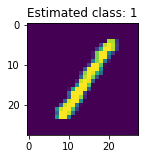

In [15]:
import random

T, l = dataset[random.randint(0,len(dataset))]
inp = T.view(1, 28*28)
plot_examples([(T,torch.argmax(model(inp)).item())])

* ### Procesing entire dataset and analyzing results

### Corrección red

In [16]:
from sklearn.metrics import confusion_matrix
def process_metrics(expected_output, estimated_output, wrong_answers):

  accuracy = 100 * float(torch.sum(expected_output == estimated_output)) / float(expected_output.size()[0])
  print("#######################METRICS#######################\n")
  print(f"Accuracy: {accuracy:.2f}%")
  expected_output,estimated_output = expected_output.cpu(),estimated_output.cpu()
  result_matrix = confusion_matrix(expected_output,estimated_output)
  print(f"Confusion Matrix: \n\n{result_matrix}\n")
  print("Total Errors per class:")
  for i in range(len(result_matrix)):
    print(f"{i}: {sum([result_matrix[j][i] for j in range(len(result_matrix)) if j != i])}")
  print(f"First 5 Errors found: ")
  plot_examples(wrong_answers)

In [19]:
from torch.utils.data import Subset, DataLoader
def calc_metrics(model, dataset, batch_size=100, device='cuda'):
  data_iterator = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  model.to(device)

  # the idea of these accumulated data in to be able to calculate the whole confusion_matrix
  # could be easily replace with something like acc += torch.sun(output == cls)
  # if the accuracy is the only desired metric
  accumulated_output = torch.tensor([],device=device).long()
  accumulated_cls = torch.tensor([],device=device).long()
  wrong_answers = []
  for inputs, cls in data_iterator:
    inputs = inputs.view(min(batch_size,inputs.size()[0]) ,28 * 28).to(device)
    cls = cls.to(device)
    output = torch.argmax(model(inputs),dim=1)
    accumulated_output = torch.cat((accumulated_output, output))
    accumulated_cls = torch.cat((accumulated_cls,cls))

    # Storing only the first 5 errors the idea is not execute this code always
    for i,e in enumerate(output == cls):
      if len(wrong_answers) == 5:
        break
      if not e:
        wrong_answers.append((inputs[i],output[i].item()))

  return process_metrics(accumulated_cls,accumulated_output,wrong_answers)

#######################METRICS#######################

Accuracy: 96.12%
Confusion Matrix: 

[[ 959    0    3    2    1    6    3    2    2    2]
 [   0 1119    4    0    0    0    4    1    7    0]
 [   4    1 1001    7    3    0    3    5    7    1]
 [   0    0    9  971    0    5    0    8   12    5]
 [   0    0    4    0  954    0    5    1    2   16]
 [   5    0    0   19    2  841    7    1   12    5]
 [   4    3    4    0   15    7  921    0    4    0]
 [   0    6   16    5    6    1    0  975    2   17]
 [   4    2    6   14    7   10    1    3  919    8]
 [   5    6    2   10   16    3    0    6    9  952]]

Total Errors per class:
0: 22
1: 18
2: 48
3: 57
4: 50
5: 32
6: 23
7: 27
8: 57
9: 54
First 5 Errors found: 


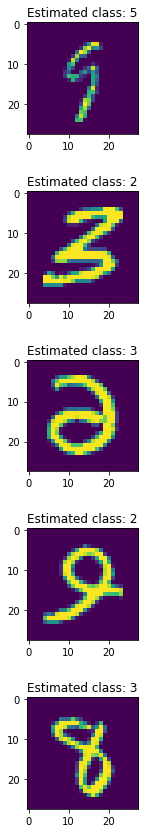

In [20]:
calc_metrics(model,dataset)

Taking a look at the confusion matrix generated above, we can find not only in which specific cases the model
is giving an incorrect answer, also we are able to see which classes are confusing with each other

* ### Running additional tests:

In [21]:
indices = corrector.get_test_data(homework=1, question="network", test=1, token=token)
test_set = Subset(dataset, indices)

# Re generating our model with fixed device
your_network = FFNN(784,[32,16],[relu,relu,softmax],10,initial_weights=pre_trained_params).cuda()
X = list(DataLoader(test_set, batch_size=len(test_set)))[0][0].view(-1, 28*28).cuda()
result = torch.argmax(your_network(X), dim=1)
corrector.sumbit(homework=1, question="network", test=1, token=token, answer=result)

Correct Test!


* ### Using custom cases to test the network

To be able to run the code below is importante to have the `test/` folder in the temporal storage enviroment. The tests used to reproduce the next results can be dowloaded from here: `https://github.com/humbertordrgs/DL_T_1/raw/develop/resources/tests.zip`.


In [22]:
custom_tests_data = ImageFolder(
        root="tests/",
        transform=Compose([
            Grayscale(num_output_channels=1),
            Resize((28, 28), interpolation=2),
            ToTensor()
        ])
    )

custom_tests_data.target_transform = lambda _id: int(
  list(
    custom_tests_data.class_to_idx.keys()
  )[list(custom_tests_data.class_to_idx.values()).index(_id)]
)

#######################METRICS#######################

Accuracy: 33.33%
Confusion Matrix: 

[[1 0 0 1 0 0 0 0 0 0]
 [0 1 1 0 0 1 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 0 0]]

Total Errors per class:
0: 0
1: 0
2: 7
3: 2
4: 0
5: 2
6: 1
7: 2
8: 0
9: 0
First 5 Errors found: 


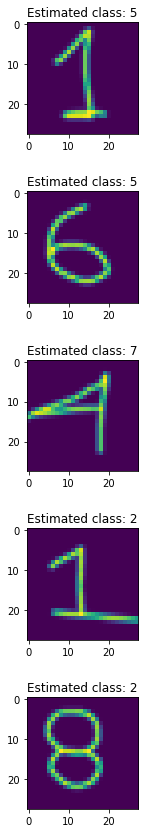

In [24]:
calc_metrics(model,custom_tests_data,batch_size=1)